In [35]:
import numpy as np
import pandas as pd

import nltk

from data_proc.proc_json import convert_time, load_individual_transcript
from data_proc import proc_json

from nltk.stem import WordNetLemmatizer

from sklearn.ensemble import RandomForestRegressor

from os import listdir

import matplotlib.pyplot as plt

import glob

In [2]:
def get_company_name(file_name: str) -> str:
    company = file_name.replace(".json", "")
    company = company.replace("./test/", "")
    return company

In [3]:
company_lst = [get_company_name(f) for f in glob.glob("./test/*.json")]
print(company_lst)

['T', 'PHM', 'TRIP', 'PAYX', 'ITW', 'OKE', 'IFF', 'PPG', 'BEN', 'PKG', 'GE', 'SYF', 'HOLX', 'A', 'COTY', 'EMN', 'BMY', 'TSCO', 'CTAS', 'PSX', 'LMT', 'TXN', 'HST', 'ETN', 'SNI', 'USB', 'APH', 'ROK', 'MAS', 'RF', 'FIS', 'MDT', 'HIG', 'MYL', 'M', 'AME', 'GPN', 'BAC', 'CI', 'AMD', 'L', 'ECL', 'SYK', 'AES', 'MCK', 'MAR', 'ALB', 'HUM', 'PEP', 'CME', 'WU', 'DISH', 'INCY', 'HLT', 'ARNC', 'KMB', 'MS', 'CBOE', 'DIS', 'ALLE', 'GPC', 'XRX', 'CNC', 'FB', 'KR', 'GD', 'CHRW', 'WY', 'COP', 'PG', 'ABT', 'BLK', 'IVZ', 'HOG', 'PCAR', 'URI', 'HSY', 'PXD', 'ILMN', 'FISV', 'SHW', 'MNST', 'VRSN', 'DE', 'MCHP', 'STI', 'NRG', 'DLTR', 'DHR', 'SYY', 'CAT', 'HBI', 'MMC', 'WLTW', 'FLR', 'MET', 'IBM', 'K', 'CINF', 'CTSH', 'MA', 'NWL', 'KMI', 'EXR', 'NAVI', 'AAL', 'ORLY', 'COST', 'SPGI', 'NFLX', 'UAL', 'AMGN', 'TWX', 'RL', 'DXC', 'LNT', 'FBHS', 'ZTS', 'BXP', 'BSX', 'SCG', 'CPB', 'F', 'VIAB', 'VFC', 'VTR', 'MSI', 'HRL', 'LLY', 'MTB', 'CELG', 'CFG', 'PNR', 'MPC', 'MKC', 'AAPL', 'UNH', 'OXY', 'JNJ', 'AVB', 'NEE', 'GWW'

# Essential Datasets

In [4]:
COMPANY_PATH = "./hackathon_data/companies.csv"
JSON_PATH = "./hackathon_data/company_transcripts/"
LMD_PATH = "./sentiment_data/LoughranMcDonald_SentimentWordLists_2018.xlsx"


LMD_Dataset = pd.read_excel(
    LMD_PATH,
    sheet_name=[
        "Negative", "Positive",
        "Uncertainty", "Litigious",
        "StrongModal", "Constraining"],
    header=None
)

LMD_hash = dict()
for k, v in LMD_Dataset.items():
    LMD_hash[k] = list(map(lambda x: x[0], v.values))


TYPES = [
    "Negative", "Positive",
    "Uncertainty", "Litigious",
    "StrongModal", "Constraining"
]


# 26 words.
financial_dataset = pd.read_excel(
    # "/Users/tianyudu/Documents/TD-Rotman-FinHub-TDMDAL-Hackathon/sentiment_data/Finance_Dic.xlsx"
    "./sentiment_data/Finance_Dic.xlsx"
)

POS_LST = list(financial_dataset["positive"].values)
NEG_LST = list(financial_dataset["negative"].values)

features = ['d_Negative', 'd_Positive', 'd_Uncertainty',
       'd_Litigious', 'd_StrongModal', 'd_Constraining', 'd_Pos_26',
       'd_Neg_26', 'qa_Negative', 'qa_Positive', 'qa_Uncertainty',
       'qa_Litigious', 'qa_StrongModal', 'qa_Constraining', 'qa_Pos_26',
       'qa_Neg_26']

# Train Models

In [5]:
df_train = pd.read_csv("./sentiment_data/QA_LMD_data_all_returns.csv")
df_train.dropna(inplace=True)

In [6]:
X_train = df_train[features].values
y_train = df_train["nearest_day_return"].values.squeeze()

In [7]:
config = {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
model = RandomForestRegressor(**config)

In [8]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Load Dataset

In [9]:
def qa_check(sentence: str) -> bool:
    sentence = sentence.lower()
    if len(sentence) > 100:
        return False
    if "questions" in sentence and "answers" in sentence:
        return True
    if "question" in sentence and "answer" in sentence:
        return True
    return False

In [10]:
ds_dis = dict()
ds_qa = dict()

places, length = list(), list()
failed = 0
for company in company_lst:
    all_transcript = proc_json.load_individual_transcript(
        company=company, path="./test/")
    for transcript_id in all_transcript["title"].keys():
        unique_id = company + "_" + transcript_id

        title = all_transcript["title"][transcript_id]
        date = all_transcript["date"][transcript_id]
        body = all_transcript["body"][transcript_id]
        # Total length of body.
        length.append(len(body))

        qa_begins = None
        for p, sentence in enumerate(body):
            if qa_check(sentence):
                qa_begins = p
                break
        if qa_begins is None:
            # If we cannot find such QA identifier.
            # Assume 0.3 Speech + 0.7 QA (aggregate prior).
            qa_begins = int(len(body) * 0.3)
            failed += 1
        places.append(qa_begins)
        # Split the dataset
        ds_dis.update({str(unique_id): " ".join(body[:qa_begins])})
        ds_qa.update({str(unique_id): " ".join(body[qa_begins:])})

# Parse Dataset

In [11]:
def get_score(
    body: str,
    prefix: str
) -> np.ndarray:
    """
    Compute sentiment for each body paragraph.
    Returns a dictionary of six values,
    counts the number of occurences of each type of words.
    """
    counts = dict((prefix + k, 0) for k in LMD_hash.keys())
    counts.update({
        prefix + "Pos_26": 0,
        prefix + "Neg_26": 0
    })

    # Tokenize.
    tokens = nltk.word_tokenize(body)
    lemmatizer = WordNetLemmatizer()
    for word_type in TYPES:
        for w in tokens:
            w = w.lower()
            c = lemmatizer.lemmatize(w)
            if c.upper() in LMD_hash[word_type]:
                counts[prefix + word_type] += 1
            if c.lower() in POS_LST:
                counts[prefix + "Pos_26"] += 1
            if c.lower() in NEG_LST:
                counts[prefix + "Neg_26"] += 1
    return counts

In [12]:
D_SPLITTED_BDOY = ds_dis
Q_SPLITTED_BDOY = ds_qa

print(f"Number of companies: {len(company_lst)}")
df_collection = {
    "ID": [],
    "Code": [],
    "Time": [],
    "d_Negative": [],
    "d_Positive": [],
    "d_Uncertainty": [],
    "d_Litigious": [],
    "d_StrongModal": [],
    "d_Constraining": [],
    "d_Pos_26": [],
    "d_Neg_26": [],
    "qa_Negative": [],
    "qa_Positive": [],
    "qa_Uncertainty": [],
    "qa_Litigious": [],
    "qa_StrongModal": [],
    "qa_Constraining": [],
    "qa_Pos_26": [],
    "qa_Neg_26": []
}

for num, company in enumerate(company_lst):
    print(f"Current Company: {company}")
    data = load_individual_transcript(company, path="./test/")
    trainscript_ids = list(data["title"].keys())
    for i in trainscript_ids:
        transcript_code = str(company) + "_" + str(i)

        t = data["date"][i]
        date = convert_time(t)

        # Compute scores for each part.
        discussion_part = D_SPLITTED_BDOY[transcript_code]
        qa_part = Q_SPLITTED_BDOY[transcript_code]

        discussion_counts = get_score(discussion_part, prefix="d_")
        qa_counts = get_score(qa_part, prefix="qa_")

        info = {
            "ID": i,
            "Code": transcript_code,
            "Time": date
        }

        info.update(discussion_counts)
        info.update(qa_counts)

        for k, v in info.items():
            df_collection[k].append(v)
df = pd.DataFrame.from_dict(df_collection)

Number of companies: 328
Current Company: T
Current Company: PHM
Current Company: TRIP
Current Company: PAYX
Current Company: ITW
Current Company: OKE
Current Company: IFF
Current Company: PPG
Current Company: BEN
Current Company: PKG
Current Company: GE
Current Company: SYF
Current Company: HOLX
Current Company: A
Current Company: COTY
Current Company: EMN
Current Company: BMY
Current Company: TSCO
Current Company: CTAS
Current Company: PSX
Current Company: LMT
Current Company: TXN
Current Company: HST
Current Company: ETN
Current Company: SNI
Current Company: USB
Current Company: APH
Current Company: ROK
Current Company: MAS
Current Company: RF
Current Company: FIS
Current Company: MDT
Current Company: HIG
Current Company: MYL
Current Company: M
Current Company: AME
Current Company: GPN
Current Company: BAC
Current Company: CI
Current Company: AMD
Current Company: L
Current Company: ECL
Current Company: SYK
Current Company: AES
Current Company: MCK
Current Company: MAR
Current Compan

In [21]:
df = pd.DataFrame.from_dict(df_collection)

654

In [26]:
X_test = df[features].values
pred = model.predict(X_test)

In [27]:
result = pd.DataFrame({
    "id": df.ID,
    "prediction": pred
})

In [28]:
result.head()

,id,prediction
0,2369,0.006860
1,2367,0.002761
2,18227,0.002095
3,18414,0.004408
4,20895,0.010920


In [44]:
result.to_csv("./final_test_result.csv")
original_result = result.copy()

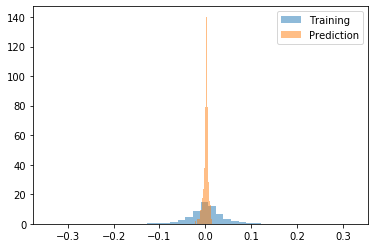

In [65]:
plt.hist(y_train, bins=40, label="Training", density=True, alpha=0.5)
plt.hist(original_result.prediction, bins=40, label="Prediction", density=True, alpha=0.5)
plt.legend()
plt.show()

In [51]:
train_std = float(np.std(y_train))
pred_std = float(np.std(result))

In [52]:
alpha = train_std / pred_std

In [53]:
alpha

8.061409664838068

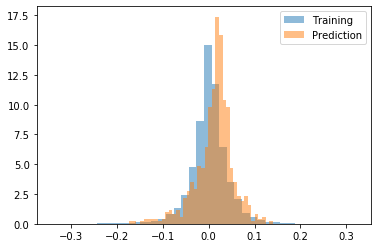

In [54]:
plt.hist(y_train, bins=40, label="Training", density=True, alpha=0.5)
plt.hist(result.prediction * alpha , bins=40, label="Prediction", density=True, alpha=0.5)
plt.legend()
plt.show()

In [58]:
modified = original_result.copy()

In [60]:
modified.prediction = modified.prediction * alpha

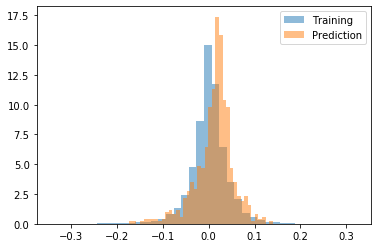

In [62]:
plt.hist(y_train, bins=40, label="Training", density=True, alpha=0.5)
plt.hist(modified.prediction, bins=40, label="Prediction", density=True, alpha=0.5)
plt.legend()
plt.show()

In [63]:
modified.to_csv("./modified_prediction.csv")

In [64]:
modified.head()

,id,prediction
0,2369,0.055304
1,2367,0.022261
2,18227,0.016887
3,18414,0.035535
4,20895,0.088033
